<h1 style="background-color:#FF00FF;font-family:Open Sans Light;font-size:250%;text-align:center;border-radius: 10px 10px;">Home Credit Default Risk Project</h1>
<img src="https://cafefcdn.com/thumb_w/650/203337114487263232/2020/9/24/photo1600945223641-1600945223860557096449.jpg"></img> <br>

## OBJECTIF:
    
Cette partie se donne comme objectif de tester les algorithmes devant permettre de prédire les probabilités de défaut des clients

# Importation des librairies 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector,make_column_transformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PolynomialFeatures,RobustScaler, OneHotEncoder,LabelBinarizer,LabelEncoder
pd.set_option('display.max_columns', 122)
pd.set_option('display.max_colwidth', 122)
from sklearn.utils import resample
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest,f_classif
import warnings
warnings.filterwarnings('ignore')

C:\Users\lenovo\AppData\Python\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\lenovo\AppData\Python\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\lenovo\AppData\Python\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


# importation du jeu de donnée

In [2]:
data=pd.read_csv("train_completement.csv")

In [3]:
data.shape

(1509345, 138)

# transformation des données 

In [5]:
def pipeline(algo,imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler()):
    # transformation des variables numerique
    var_nu=make_column_selector(dtype_include=np.number)
    tranf_var_nu=Pipeline(steps=[("imputer", imput_num),("scaler",scaler)])
    # transformation des variables categoriel
    var_cat=make_column_selector(dtype_exclude=np.number)
    tranf_var_cat=make_pipeline(imput_var,OneHotEncoder(handle_unknown='ignore'))
    # construction du transformateur
    preparation=ColumnTransformer(transformers=[("num", tranf_var_nu, var_nu),("cat", tranf_var_cat, var_cat)])
    modele=Pipeline(steps=[("preprocessor", preparation),("selec",SelectKBest(f_classif,k=35)),("feature",PolynomialFeatures(2)),("model", algo)])
    return modele


# separation des featurres et du target

In [17]:
x=data.drop("TARGET",axis=1)
y=data["TARGET"]

# distribution des target

In [18]:
y.value_counts(normalize=True)

0    0.921173
1    0.078827
Name: TARGET, dtype: float64

# division du dataset en trainset et testset

In [19]:
import random
seed=0
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=seed,stratify=y)
print(x_train.shape)
print(x_test.shape)

(1207476, 137)
(301869, 137)


# creation du data set pour la validation

In [20]:
x_val,x_test,y_val,y_test=train_test_split(x_test,y_test,test_size=0.5,random_state=seed,stratify=y_test)

# distrubition du target dans les datasets crée

In [21]:
print( "dans la base application \n", y.value_counts(normalize=True))
print("*****************************************************************************************")
print( "dans la base train set  application \n",y_train.value_counts(normalize=True))
print("*****************************************************************************************")
print("dans la base test set  application \n",y_train.value_counts(normalize=True))

dans la base application 
 0    0.921173
1    0.078827
Name: TARGET, dtype: float64
*****************************************************************************************
dans la base train set  application 
 0    0.921173
1    0.078827
Name: TARGET, dtype: float64
*****************************************************************************************
dans la base test set  application 
 0    0.921173
1    0.078827
Name: TARGET, dtype: float64


## Phase de la Modélisation sur le jeu deséquilibré

 # modèle1 : la regression logistique

In [ ]:
modele1=pipeline(algo=LogisticRegression(solver='saga',max_iter = 200,random_state=seed ),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

# entrainement du modèle1

In [97]:
modele1.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000215640C4100>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000215640C4E20>)])),
                ('logist_regressor',
                 LogisticRegression(max_iter=200, random_state=0,
                                    solver='saga'))])

## Fonction de mesure de la performance du modèle

In [40]:
def testemodel(model):
    y_pred=model.predict(x_val)
    target_name=["prêt_non_risqué","prêt_risqué"]
    print("la matrice de confusion:\n")
    print(confusion_matrix(y_val,y_pred,normalize="all")*100)
    print("le rapport de classification:\n")
    print(classification_report(y_val,y_pred,target_names=target_name))
    ConfusionMatrixDisplay.from_predictions(y_val,y_pred)
    

# resultat du modèle1

la matrice de confusion:

[[9.20362543e+01 8.14925729e-02]
 [7.80208568e+00 8.01674904e-02]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.92      1.00      0.96    139037
    prêt_risqué       0.50      0.01      0.02     11897

       accuracy                           0.92    150934
      macro avg       0.71      0.50      0.49    150934
   weighted avg       0.89      0.92      0.88    150934



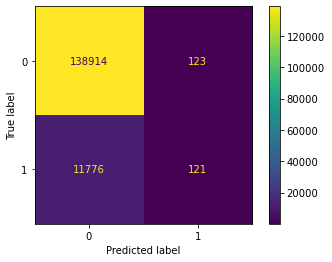

In [104]:
testemodel(modele1)

# commentaire

# modèle 2: XGClassifier

In [6]:
modele2=pipeline(algo=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

# entrainement du modèle

In [24]:
modele2.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021403C88970>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant'))...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

# resultat du modèle 2

la matrice de confusion:

[[91.9613871   0.15635973]
 [ 6.86193966  1.02031351]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.93      1.00      0.96    139037
    prêt_risqué       0.87      0.13      0.23     11897

       accuracy                           0.93    150934
      macro avg       0.90      0.56      0.59    150934
   weighted avg       0.93      0.93      0.91    150934



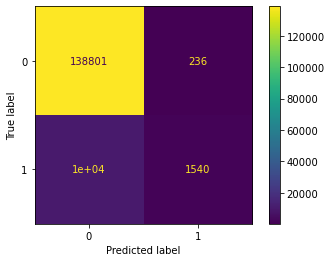

In [25]:
testemodel(modele2)

# commentaire 2 

## resolution du problème de désequilibre des groupes

# le sous-échantillonnage

In [24]:
## creation des categories 
x1=x_train
x1["TARGET"]=y_train.values
## la classe minoritaire
mino=x1[x1["TARGET"]==1]
print(mino.shape)
majo=x1[x1["TARGET"]==0]
print(majo.shape)
majo_rechant= resample(majo,replace=False,n_samples=mino.shape[0])

(95182, 138)
(1112294, 138)


In [25]:
majo_rechant.shape

(95182, 138)

# reconstitution de la base sous échantionnée

In [26]:
rechantsous=pd.concat([mino,majo_rechant],axis=0)

In [27]:
rechantsous.shape

(190364, 138)

# verification du trainset équilibré souséchant

In [28]:
rechantsous["TARGET"].value_counts(normalize=True)

1    0.5
0    0.5
Name: TARGET, dtype: float64

## Phase de la Modélisation sur le jeu équilibré

### division du jeu de donnée équilibré souséchantillonnage

In [29]:
x_train_sous=rechantsous.drop("TARGET",axis=1)
y_train_sous=rechantsous["TARGET"]

In [30]:
print(x_train_sous.shape)
print(y_train_sous.shape)

(190364, 137)
(190364,)


 # modèle1 : la regression logistique

In [31]:
 model1=pipeline(algo=LogisticRegression(random_state=seed ))

# entrainement du modèle1

In [115]:
model1.fit(x_train_sous, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000215646D4BB0>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000215646D4A90>)])),
                ('model',
                 LogisticRegression(max_iter=200, random_state=0,
                                    solver='saga'))])

# resulat du modèle

la matrice de confusion:

[[63.59799648 28.51975035]
 [ 2.47525408  5.40699909]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.96      0.69      0.80    139037
    prêt_risqué       0.16      0.69      0.26     11897

       accuracy                           0.69    150934
      macro avg       0.56      0.69      0.53    150934
   weighted avg       0.90      0.69      0.76    150934



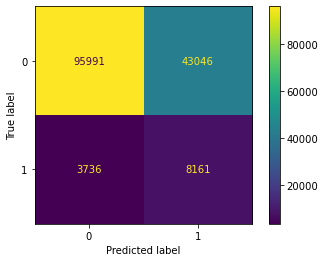

In [116]:
testemodel(model1)

# commentaire

# modèle 2: XGClassifier

In [32]:
model2=pipeline(algo=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='most_frequent'),scaler=StandardScaler())

# entrainement du modèle2

In [122]:
model2.fit(x_train_sous, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021563C1B2B0>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneH...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

# resultat du modèle2

la matrice de confusion:

[[70.26117376 21.85657307]
 [ 1.69014271  6.19211046]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.98      0.76      0.86    139037
    prêt_risqué       0.22      0.79      0.34     11897

       accuracy                           0.76    150934
      macro avg       0.60      0.77      0.60    150934
   weighted avg       0.92      0.76      0.82    150934



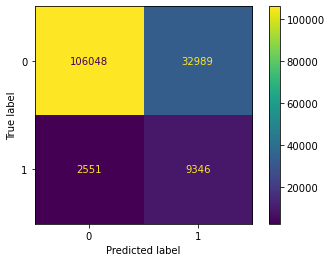

In [123]:
testemodel(model2)

# Modèle3: LGBClassifier

In [34]:
modele3=pipeline(algo=LGBMClassifier(),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

In [40]:
model3.fit(x_train_sous, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021403C88970>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021403C880A0>)])),
                ('LGBMClassifier', LGBMClassifier())])

# resultat du modèle3

la matrice de confusion:

[[66.77686936 25.34087747]
 [ 2.17843561  5.70381756]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.97      0.72      0.83    139037
    prêt_risqué       0.18      0.72      0.29     11897

       accuracy                           0.72    150934
      macro avg       0.58      0.72      0.56    150934
   weighted avg       0.91      0.72      0.79    150934



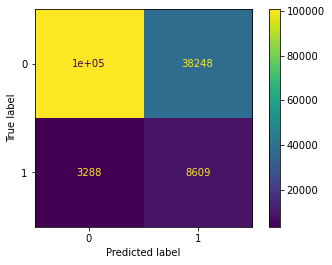

In [41]:
testemodel(model3)

# modèle 4: CatBoostClassifier

In [35]:
modele4=pipeline(algo=CatBoostClassifier(),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

# entrainement du modèle 

In [43]:
model4.fit(x_train_sous, y_train_sous)

Learning rate set to 0.096898
0:	learn: 0.6788554	total: 313ms	remaining: 5m 12s
1:	learn: 0.6665674	total: 423ms	remaining: 3m 30s
2:	learn: 0.6565894	total: 533ms	remaining: 2m 57s
3:	learn: 0.6486398	total: 633ms	remaining: 2m 37s
4:	learn: 0.6416040	total: 741ms	remaining: 2m 27s
5:	learn: 0.6357477	total: 843ms	remaining: 2m 19s
6:	learn: 0.6308696	total: 967ms	remaining: 2m 17s
7:	learn: 0.6263646	total: 1.07s	remaining: 2m 12s
8:	learn: 0.6228194	total: 1.17s	remaining: 2m 9s
9:	learn: 0.6195779	total: 1.28s	remaining: 2m 7s
10:	learn: 0.6168110	total: 1.38s	remaining: 2m 3s
11:	learn: 0.6144141	total: 1.46s	remaining: 2m
12:	learn: 0.6121201	total: 1.57s	remaining: 1m 59s
13:	learn: 0.6101397	total: 1.68s	remaining: 1m 58s
14:	learn: 0.6085281	total: 1.77s	remaining: 1m 56s
15:	learn: 0.6069360	total: 1.87s	remaining: 1m 54s
16:	learn: 0.6055599	total: 1.97s	remaining: 1m 54s
17:	learn: 0.6042651	total: 2.06s	remaining: 1m 52s
18:	learn: 0.6030251	total: 2.16s	remaining: 1m 51s

157:	learn: 0.5571568	total: 15.7s	remaining: 1m 23s
158:	learn: 0.5568674	total: 15.8s	remaining: 1m 23s
159:	learn: 0.5564758	total: 15.9s	remaining: 1m 23s
160:	learn: 0.5561860	total: 16s	remaining: 1m 23s
161:	learn: 0.5559367	total: 16.1s	remaining: 1m 23s
162:	learn: 0.5557359	total: 16.2s	remaining: 1m 23s
163:	learn: 0.5554941	total: 16.3s	remaining: 1m 22s
164:	learn: 0.5552278	total: 16.4s	remaining: 1m 22s
165:	learn: 0.5550301	total: 16.5s	remaining: 1m 22s
166:	learn: 0.5547850	total: 16.6s	remaining: 1m 22s
167:	learn: 0.5545332	total: 16.7s	remaining: 1m 22s
168:	learn: 0.5542316	total: 16.8s	remaining: 1m 22s
169:	learn: 0.5540212	total: 16.9s	remaining: 1m 22s
170:	learn: 0.5538363	total: 16.9s	remaining: 1m 22s
171:	learn: 0.5536803	total: 17s	remaining: 1m 22s
172:	learn: 0.5534947	total: 17.2s	remaining: 1m 22s
173:	learn: 0.5532087	total: 17.3s	remaining: 1m 21s
174:	learn: 0.5529664	total: 17.3s	remaining: 1m 21s
175:	learn: 0.5527415	total: 17.4s	remaining: 1m 2

313:	learn: 0.5241242	total: 32.4s	remaining: 1m 10s
314:	learn: 0.5239671	total: 32.5s	remaining: 1m 10s
315:	learn: 0.5237240	total: 32.6s	remaining: 1m 10s
316:	learn: 0.5235397	total: 32.8s	remaining: 1m 10s
317:	learn: 0.5233286	total: 32.9s	remaining: 1m 10s
318:	learn: 0.5231619	total: 33s	remaining: 1m 10s
319:	learn: 0.5229507	total: 33.1s	remaining: 1m 10s
320:	learn: 0.5227537	total: 33.3s	remaining: 1m 10s
321:	learn: 0.5225899	total: 33.4s	remaining: 1m 10s
322:	learn: 0.5224088	total: 33.5s	remaining: 1m 10s
323:	learn: 0.5222611	total: 33.6s	remaining: 1m 10s
324:	learn: 0.5220476	total: 33.7s	remaining: 1m 10s
325:	learn: 0.5218822	total: 33.8s	remaining: 1m 9s
326:	learn: 0.5216638	total: 33.9s	remaining: 1m 9s
327:	learn: 0.5215019	total: 34.1s	remaining: 1m 9s
328:	learn: 0.5211996	total: 34.2s	remaining: 1m 9s
329:	learn: 0.5210725	total: 34.3s	remaining: 1m 9s
330:	learn: 0.5208043	total: 34.4s	remaining: 1m 9s
331:	learn: 0.5206558	total: 34.5s	remaining: 1m 9s
33

472:	learn: 0.4964694	total: 51.4s	remaining: 57.3s
473:	learn: 0.4963369	total: 51.6s	remaining: 57.2s
474:	learn: 0.4962691	total: 51.7s	remaining: 57.1s
475:	learn: 0.4960949	total: 51.8s	remaining: 57.1s
476:	learn: 0.4959966	total: 52s	remaining: 57s
477:	learn: 0.4958493	total: 52.1s	remaining: 56.9s
478:	learn: 0.4956481	total: 52.3s	remaining: 56.9s
479:	learn: 0.4954543	total: 52.5s	remaining: 56.8s
480:	learn: 0.4953189	total: 52.6s	remaining: 56.7s
481:	learn: 0.4951706	total: 52.7s	remaining: 56.7s
482:	learn: 0.4950491	total: 52.8s	remaining: 56.6s
483:	learn: 0.4948881	total: 53.1s	remaining: 56.6s
484:	learn: 0.4947236	total: 53.2s	remaining: 56.5s
485:	learn: 0.4945409	total: 53.3s	remaining: 56.4s
486:	learn: 0.4943529	total: 53.5s	remaining: 56.3s
487:	learn: 0.4941654	total: 53.6s	remaining: 56.2s
488:	learn: 0.4940350	total: 53.7s	remaining: 56.2s
489:	learn: 0.4939155	total: 53.9s	remaining: 56.1s
490:	learn: 0.4937790	total: 54s	remaining: 56s
491:	learn: 0.493633

631:	learn: 0.4731155	total: 1m 12s	remaining: 42.4s
632:	learn: 0.4729864	total: 1m 12s	remaining: 42.2s
633:	learn: 0.4728276	total: 1m 12s	remaining: 42.1s
634:	learn: 0.4726565	total: 1m 13s	remaining: 42s
635:	learn: 0.4724858	total: 1m 13s	remaining: 41.9s
636:	learn: 0.4723213	total: 1m 13s	remaining: 41.8s
637:	learn: 0.4721825	total: 1m 13s	remaining: 41.7s
638:	learn: 0.4720565	total: 1m 13s	remaining: 41.6s
639:	learn: 0.4719570	total: 1m 13s	remaining: 41.5s
640:	learn: 0.4718082	total: 1m 13s	remaining: 41.4s
641:	learn: 0.4716784	total: 1m 13s	remaining: 41.3s
642:	learn: 0.4715591	total: 1m 14s	remaining: 41.1s
643:	learn: 0.4714042	total: 1m 14s	remaining: 41s
644:	learn: 0.4712800	total: 1m 14s	remaining: 40.9s
645:	learn: 0.4711760	total: 1m 14s	remaining: 40.8s
646:	learn: 0.4710410	total: 1m 14s	remaining: 40.7s
647:	learn: 0.4708832	total: 1m 14s	remaining: 40.6s
648:	learn: 0.4707569	total: 1m 14s	remaining: 40.5s
649:	learn: 0.4705525	total: 1m 15s	remaining: 40.

787:	learn: 0.4521039	total: 1m 31s	remaining: 24.6s
788:	learn: 0.4520602	total: 1m 31s	remaining: 24.5s
789:	learn: 0.4519648	total: 1m 31s	remaining: 24.4s
790:	learn: 0.4517984	total: 1m 31s	remaining: 24.2s
791:	learn: 0.4517051	total: 1m 31s	remaining: 24.1s
792:	learn: 0.4515593	total: 1m 31s	remaining: 24s
793:	learn: 0.4514514	total: 1m 32s	remaining: 23.9s
794:	learn: 0.4513665	total: 1m 32s	remaining: 23.8s
795:	learn: 0.4512638	total: 1m 32s	remaining: 23.6s
796:	learn: 0.4511273	total: 1m 32s	remaining: 23.5s
797:	learn: 0.4509665	total: 1m 32s	remaining: 23.4s
798:	learn: 0.4508049	total: 1m 32s	remaining: 23.3s
799:	learn: 0.4506936	total: 1m 32s	remaining: 23.2s
800:	learn: 0.4505741	total: 1m 32s	remaining: 23.1s
801:	learn: 0.4504091	total: 1m 32s	remaining: 23s
802:	learn: 0.4503221	total: 1m 33s	remaining: 22.8s
803:	learn: 0.4502512	total: 1m 33s	remaining: 22.7s
804:	learn: 0.4501483	total: 1m 33s	remaining: 22.6s
805:	learn: 0.4499964	total: 1m 33s	remaining: 22.

943:	learn: 0.4335930	total: 1m 47s	remaining: 6.37s
944:	learn: 0.4334661	total: 1m 47s	remaining: 6.26s
945:	learn: 0.4332796	total: 1m 47s	remaining: 6.14s
946:	learn: 0.4331975	total: 1m 47s	remaining: 6.03s
947:	learn: 0.4330925	total: 1m 47s	remaining: 5.91s
948:	learn: 0.4329932	total: 1m 47s	remaining: 5.8s
949:	learn: 0.4328952	total: 1m 48s	remaining: 5.68s
950:	learn: 0.4327857	total: 1m 48s	remaining: 5.57s
951:	learn: 0.4326507	total: 1m 48s	remaining: 5.46s
952:	learn: 0.4325253	total: 1m 48s	remaining: 5.34s
953:	learn: 0.4324152	total: 1m 48s	remaining: 5.22s
954:	learn: 0.4322969	total: 1m 48s	remaining: 5.11s
955:	learn: 0.4321823	total: 1m 48s	remaining: 5s
956:	learn: 0.4320804	total: 1m 48s	remaining: 4.88s
957:	learn: 0.4320089	total: 1m 48s	remaining: 4.77s
958:	learn: 0.4319329	total: 1m 48s	remaining: 4.65s
959:	learn: 0.4318112	total: 1m 48s	remaining: 4.54s
960:	learn: 0.4316946	total: 1m 49s	remaining: 4.43s
961:	learn: 0.4316075	total: 1m 49s	remaining: 4.3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021403C88970>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021403C880A0>)])),
                ('CatBoostClassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000021403BC9970>)])

# reusltat du modèle 4

la matrice de confusion:

[[71.73002769 20.38771914]
 [ 1.52516994  6.35708323]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.98      0.78      0.87    139037
    prêt_risqué       0.24      0.81      0.37     11897

       accuracy                           0.78    150934
      macro avg       0.61      0.79      0.62    150934
   weighted avg       0.92      0.78      0.83    150934



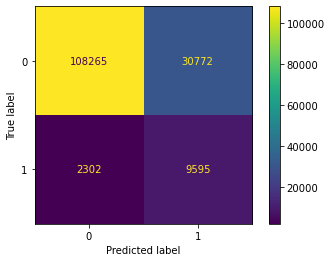

In [44]:
testemodel(model4)

# commentaire


# modèle 5 : RandomForest

In [37]:
model5=pipeline(algo=RandomForestClassifier(random_state=seed),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

In [38]:
model5.fit(x_train_sous, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF44D81C10>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BFA1D29850>)])),
                ('model', RandomForestClassifier(random_state=0))])

la matrice de confusion:

[[85.50227252  6.61547431]
 [ 0.44721534  7.43503783]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.99      0.93      0.96    139037
    prêt_risqué       0.53      0.94      0.68     11897

       accuracy                           0.93    150934
      macro avg       0.76      0.94      0.82    150934
   weighted avg       0.96      0.93      0.94    150934



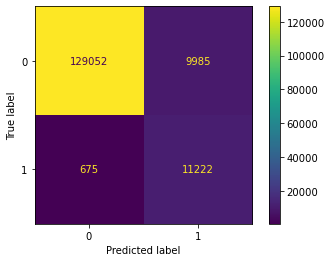

In [41]:
testemodel(model5)

# commentaire

## phase de  selection des variables importantes

In [83]:
len(model5[:-1].get_feature_names_out())

284

In [84]:
 nom_var=model5[:-1].get_feature_names_out()

### graphique des variables en fonction de leur niveau d'importance

In [85]:
vars_import=pd.Series(model5[-1].feature_importances_, index=nom_var).sort_values(ascending=False)


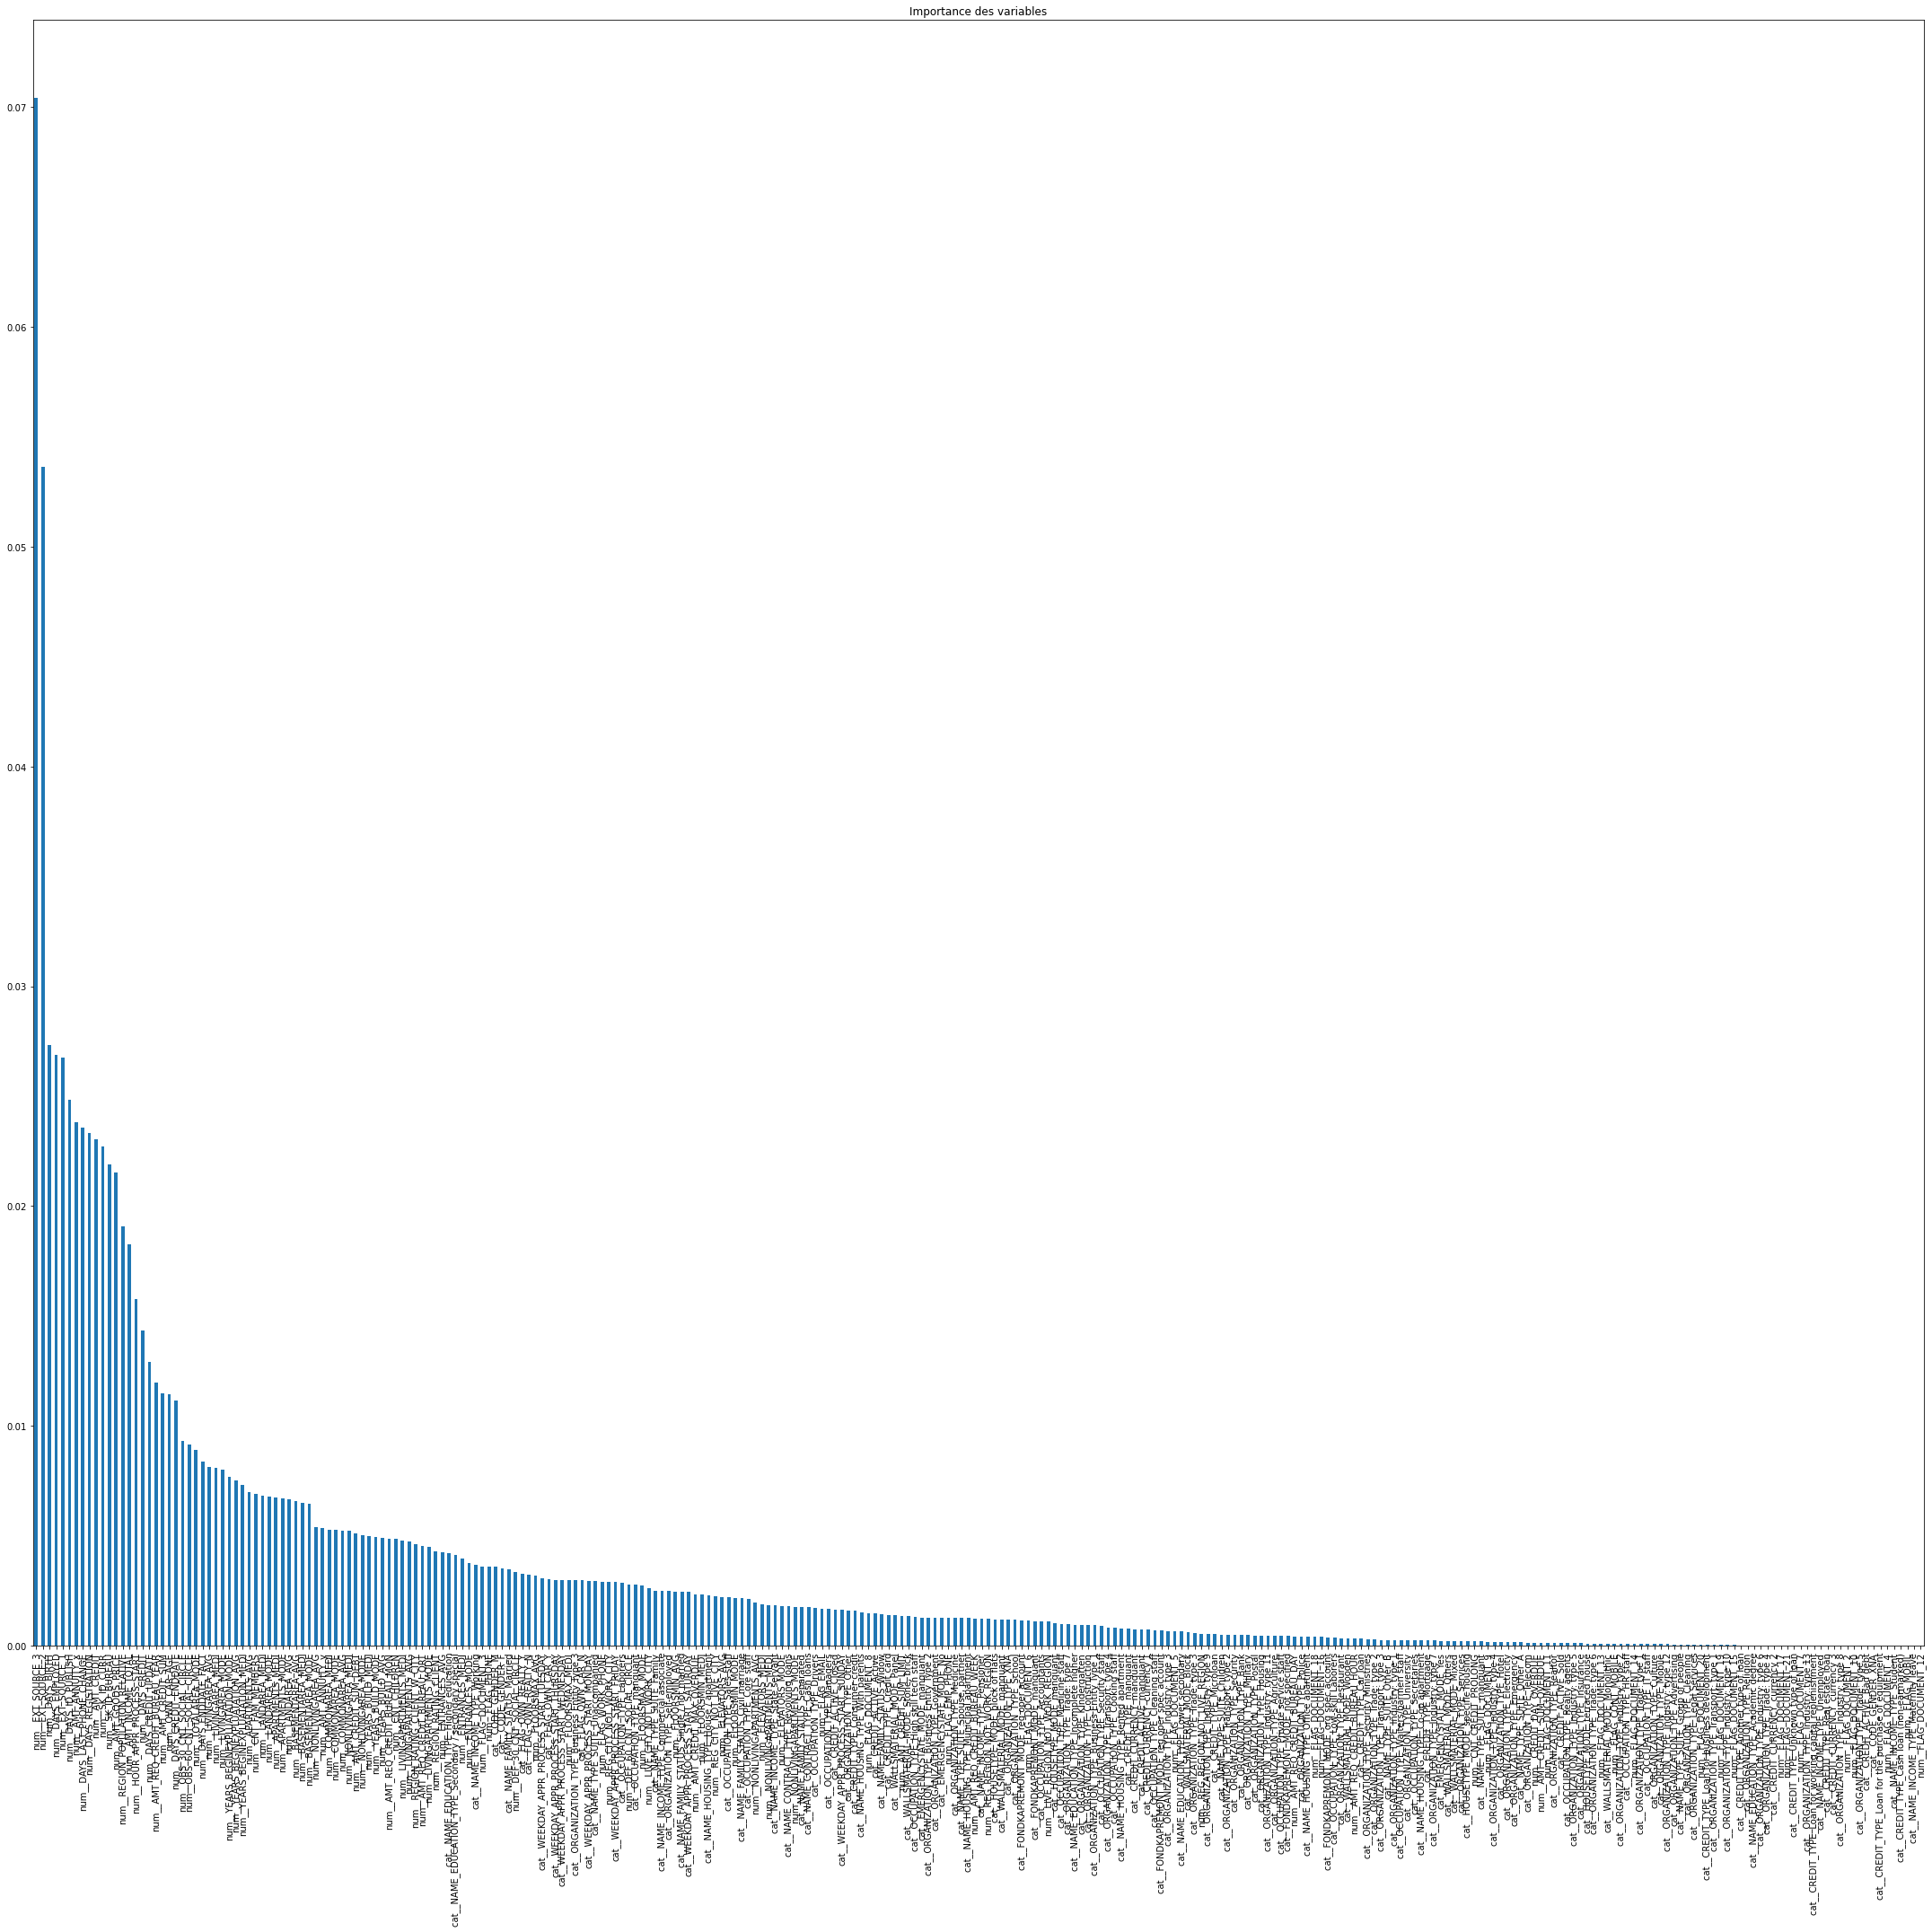

In [87]:
plt.figure(figsize=(30,30))
ax = vars_import.plot.bar()
ax.set_title("Importance des variables")
ax.figure.tight_layout()

# commentaire

In [155]:
var_selection=vars_import[vars_import>0.006]

In [156]:
var_importante=var_selection.index.to_list()

In [157]:
len(var_importante)

42

In [159]:
var_importante 

['num__EXT_SOURCE_3',
 'num__EXT_SOURCE_2',
 'num__DAYS_BIRTH',
 'num__DAYS_EMPLOYED',
 'num__EXT_SOURCE_1',
 'num__DAYS_ID_PUBLISH',
 'num__AMT_ANNUITY_x',
 'num__DAYS_LAST_PHONE_CHANGE',
 'num__DAYS_REGISTRATION',
 'num__AMT_CREDIT',
 'num__SK_ID_CURR',
 'num__SK_ID_BUREAU',
 'num__AMT_GOODS_PRICE',
 'num__REGION_POPULATION_RELATIVE',
 'num__AMT_INCOME_TOTAL',
 'num__HOUR_APPR_PROCESS_START',
 'num__DAYS_CREDIT',
 'num__DAYS_CREDIT_UPDATE',
 'num__AMT_REQ_CREDIT_BUREAU_YEAR',
 'num__AMT_CREDIT_SUM',
 'num__OWN_CAR_AGE',
 'num__DAYS_CREDIT_ENDDATE',
 'num__OBS_30_CNT_SOCIAL_CIRCLE',
 'num__OBS_60_CNT_SOCIAL_CIRCLE',
 'num__TOTALAREA_MODE',
 'num__DAYS_ENDDATE_FACT',
 'num__LIVINGAREA_AVG',
 'num__LIVINGAREA_MEDI',
 'num__LIVINGAREA_MODE',
 'num__YEARS_BEGINEXPLUATATION_MODE',
 'num__YEARS_BEGINEXPLUATATION_AVG',
 'num__YEARS_BEGINEXPLUATATION_MEDI',
 'num__APARTMENTS_AVG',
 'num__CNT_FAM_MEMBERS',
 'num__LANDAREA_MEDI',
 'num__LANDAREA_MODE',
 'num__APARTMENTS_MEDI',
 'num__APARTMENTS

In [160]:
varia=['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'DAYS_ID_PUBLISH',
 'AMT_ANNUITY_x',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'AMT_CREDIT',
 'SK_ID_CURR',
 'SK_ID_BUREAU',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL',
 'HOUR_APPR_PROCESS_START',
 'DAYS_CREDIT',
 'DAYS_CREDIT_UPDATE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_CREDIT_SUM',
 'OWN_CAR_AGE',
 'DAYS_CREDIT_ENDDATE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'TOTALAREA_MODE',
 'DAYS_ENDDATE_FACT',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'APARTMENTS_AVG',
 'CNT_FAM_MEMBERS',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'LANDAREA_AVG',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE']

In [161]:
x_train1=x_train_sous[varia]
x_val1=x_val[varia]
x_test1=x_test[varia]

In [162]:
print(x_train1.shape)
print(x_val1.shape)
print(x_test1.shape)

(190364, 42)
(150934, 42)
(150935, 42)


In [189]:
model=pipeline(algo=RandomForestClassifier(random_state=seed),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

In [190]:
model.fit(x_train1, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF46ACDD90>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF46ACDE50>)])),
                ('model', RandomForestClassifier(random_state=0))])

In [182]:
def testemodel(modele):
    y_pred=modele.predict(x_val1)
    target_name=["prêt_non_risqué","prêt_risqué"]
    print("la matrice de confusion:\n")
    print(confusion_matrix(y_val,y_pred,normalize="all")*100)
    print("le rapport de classification:\n")
    print(classification_report(y_val,y_pred,target_names=target_name))
    ConfusionMatrixDisplay.from_predictions(y_val,y_pred)
    

la matrice de confusion:

[[85.41084182  6.706905  ]
 [ 0.42932673  7.45292644]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.99      0.93      0.96    139037
    prêt_risqué       0.53      0.95      0.68     11897

       accuracy                           0.93    150934
      macro avg       0.76      0.94      0.82    150934
   weighted avg       0.96      0.93      0.94    150934



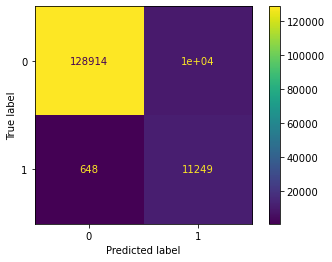

In [192]:
testemodel(model)

# Commentaire

# la technique de feature ingenieur

In [231]:
modele=pipeline(algo=RandomForestClassifier(random_state=seed),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

In [232]:
modele.fit(x_train1, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF46A9A730>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF46A9ADF0>)])),
                ('selec', SelectKBest(k=35)), ('feature', PolynomialFeatures()),
                ('model', RandomForestClassifier(random_state=0))])

la matrice de confusion:

[[86.80284098  5.31490585]
 [ 0.41806352  7.46418965]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       1.00      0.94      0.97    139037
    prêt_risqué       0.58      0.95      0.72     11897

       accuracy                           0.94    150934
      macro avg       0.79      0.94      0.85    150934
   weighted avg       0.96      0.94      0.95    150934



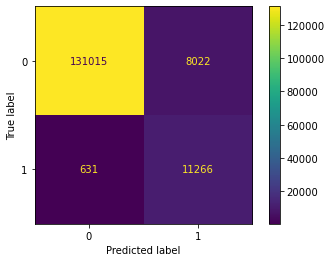

In [233]:
testemodel(modele)

In [174]:
modela=pipeline(algo=RandomForestClassifier(random_state=seed),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

In [175]:
modela.fit(x_train1, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF802BF970>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF802BF4F0>)])),
                ('feature', PolynomialFeatures()),
                ('model', RandomForestClassifier(random_state=0))])

la matrice de confusion:

[[87.53494905  4.58279778]
 [ 0.39951237  7.4827408 ]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       1.00      0.95      0.97    139037
    prêt_risqué       0.62      0.95      0.75     11897

       accuracy                           0.95    150934
      macro avg       0.81      0.95      0.86    150934
   weighted avg       0.97      0.95      0.95    150934



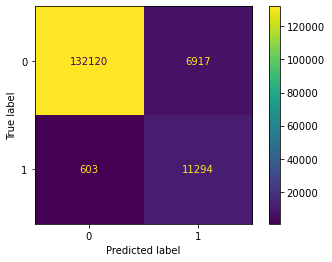

In [191]:
testemodel(modela)

# commentaire 

# Optimisation avec RandomizedSearchCV

In [205]:
modelb=pipeline(algo=RandomForestClassifier(random_state=seed),imput_num=SimpleImputer(strategy="median"),imput_var=SimpleImputer(strategy='constant', fill_value='manquant'),scaler=StandardScaler())

In [206]:
modelb.fit(x_train1, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF8028F2B0>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF8028FAF0>)])),
                ('feature', PolynomialFeatures()), ('selec', SelectKBest(k=30)),
                ('model', RandomForestClassifier(random_state=0))])

la matrice de confusion:

[[84.94640041  7.17134642]
 [ 0.44787788  7.43437529]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       0.99      0.92      0.96    139037
    prêt_risqué       0.51      0.94      0.66     11897

       accuracy                           0.92    150934
      macro avg       0.75      0.93      0.81    150934
   weighted avg       0.96      0.92      0.93    150934



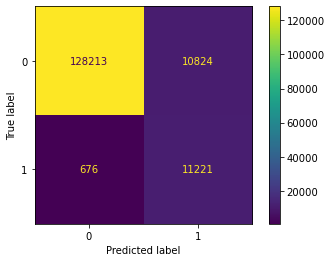

In [207]:
testemodel(modelb)

In [241]:
param_grid = [{"selec__k":range(1,43),
               "preprocessor__num__imputer__strategy": ["mean", "median"],
               "preprocessor__num__scaler": [StandardScaler(),RobustScaler()],
              "feature__degree":[2,3]}]

grid_search1 = RandomizedSearchCV(modele, param_grid, cv=5, scoring="f1",n_iter=10)


In [216]:
grid_search.fit(x_train1, y_train_sous)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF8028F2B0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(fill_value='ma...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF8028FAF0>)])),
                                             ('feature', PolynomialFeatures()),
                                             ('selec', SelectKBest(k=30)),
                                             ('model',
                                              RandomForestClassifier(random_state=0))]),
                   param_distributions=[{'feature__degree': [2, 3, 4],
                                         'preprocessor__num__imputer__strategy': ['mean',
                                                                                  'median',
                                                                                  'most_frequent'],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       RobustScaler()],
                                         'selec__k': range(1, 42)}],
                   scoring='f1')

In [217]:
grid_search.best_params_

{'selec__k': 24,
 'preprocessor__num__scaler': StandardScaler(),
 'preprocessor__num__imputer__strategy': 'mean',
 'feature__degree': 2}

In [219]:
model_final=grid_search.best_estimator_

In [220]:
model_final.fit(x_train1, y_train_sous)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF468D6E20>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='manquant',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF468D69A0>)])),
                ('feature', PolynomialFeatures()), ('selec', SelectKBest(k=24)),
                ('model', RandomForestClassifier(random_state=0))])

la matrice de confusion:

[[85.64405634  6.47369049]
 [ 0.41673844  7.46551473]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       1.00      0.93      0.96    139037
    prêt_risqué       0.54      0.95      0.68     11897

       accuracy                           0.93    150934
      macro avg       0.77      0.94      0.82    150934
   weighted avg       0.96      0.93      0.94    150934



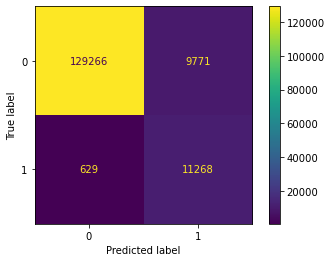

In [244]:
testemodel(model_final)

# commentaire

la matrice de confusion:

[[87.53494905  4.58279778]
 [ 0.39951237  7.4827408 ]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       1.00      0.95      0.97    139037
    prêt_risqué       0.62      0.95      0.75     11897

       accuracy                           0.95    150934
      macro avg       0.81      0.95      0.86    150934
   weighted avg       0.97      0.95      0.95    150934



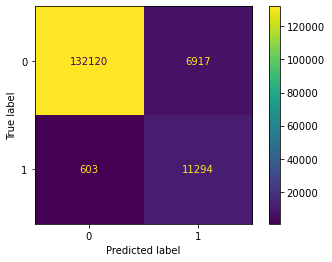

In [245]:
testemodel(modela)

# validation finale du modèle avec le testset

In [247]:
x_test1.shape

(150935, 42)

In [249]:
def testemodel(modele):
    y_pred=modele.predict(x_test1)
    target_name=["prêt_non_risqué","prêt_risqué"]
    print("la matrice de confusion:\n")
    print(confusion_matrix(y_test,y_pred,normalize="all")*100)
    print("le rapport de classification:\n")
    print(classification_report(y_test,y_pred,target_names=target_name))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    

la matrice de confusion:

[[87.39788651  4.71925001]
 [ 0.40944778  7.47341571]]
le rapport de classification:

                 precision    recall  f1-score   support

prêt_non_risqué       1.00      0.95      0.97    139037
    prêt_risqué       0.61      0.95      0.74     11898

       accuracy                           0.95    150935
      macro avg       0.80      0.95      0.86    150935
   weighted avg       0.97      0.95      0.95    150935



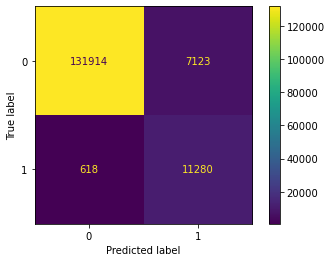

In [250]:
testemodel(modela)

# commentaire 

In [251]:
print(modela.score(x_train1, y_train_sous))
print(modela.score(x_val1, y_val))
print(modela.score(x_test1, y_test))

1.0
0.9501768985119323
0.9487130221618577


# Commentaire

###  Fonction de detection des prêts risqués et non risqués 

In [252]:
def Predict(modele,base,id):
    x=base.iloc[[id],:]
    (modele.predict(x))
    if modele.predict(x)==np.array(0):
        print("Ce prêt est non risqué avec une probabilité de:",modele.predict_proba(x)[0][0]*100,"%")
    else:
        print("Ce prêt est risqué avec une probabilité de:",modele.predict_proba(x)[0][1]*100,"%")
   

In [254]:
Predict(modela,x_test,78)

Ce prêt est risqué avec une probabilité de: 89.0 %


In [256]:
Predict(modela,x_test,145)

Ce prêt est non risqué avec une probabilité de: 93.0 %


# CONCLUSION

<h1 style="background-color:#ADFF2F;font-family:open sans light;font-size:260%;text-align:center;border-radius: 10px 10px;"> MERCI POUR VOTRE AIMABLE ATTENTION  </h1>

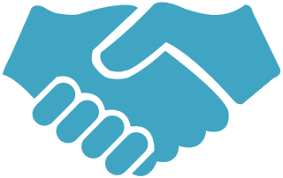